In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
df=pd.read_csv('/home/maria/waveform_classification/data/waveform_classification_summary_data_features.csv', sep='\t', index_col=0)
waveforms2d=np.load('/home/maria/waveform_classification/data/waveform_classification_summary_data_2Dwaveform.npy')

In [12]:
df.head()

,Below_soma,Above_soma,Spread,Amplitude,Duration,PTratio,RSlope,CSlope,FSRS,ID,File,area,new_type,area_id,within_labels
1,1.166667,2.666667,7,0.047439,0.425796,0.224925,0.041211,-0.044581,0.0,143,0,V1,rs,7.0,1.0
2,-3.833333,0.833333,8,0.048494,0.302178,0.751777,0.042935,-0.207889,1.0,140,0,V1,fs,7.0,0.0
3,0.833333,0.666667,10,0.072349,0.673032,0.397595,0.071316,-0.062895,0.0,124,0,V1,rs,7.0,1.0
4,2.000000,1.166667,8,0.163006,0.686767,0.406901,0.142921,-0.267282,0.0,119,0,V1,rs,7.0,1.0
5,0.000000,2.321429,9,0.091047,0.164824,0.519036,0.035709,-0.447084,1.0,133,0,V1,fs,7.0,0.0


In [5]:
waveforms2d.shape

(2818, 60, 30)

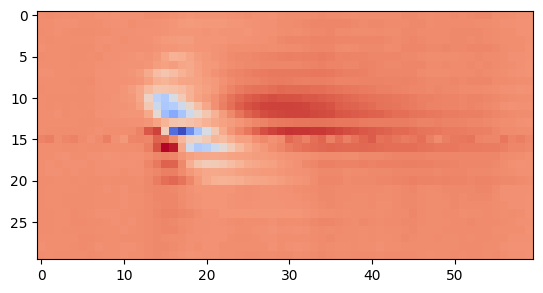

In [7]:
plt.imshow(waveforms2d[0,:,:].T,'coolwarm')

In [15]:
# Assuming your labels are stored in a pandas DataFrame called 'df'
# and waveforms are stored in a numpy array called 'waveforms'

# Convert labels to numpy array
labels = df['FSRS'].values

# Shuffle the data
np.random.seed(42)  # Set random seed for reproducibility
shuffled_indices = np.random.permutation(len(waveforms2d))
shuffled_waveforms = waveforms2d[shuffled_indices]
shuffled_labels = labels[shuffled_indices]

# Calculate the number of samples for each set
total_samples = len(waveforms2d)
train_samples = int(0.6 * total_samples)
val_samples = int(0.2 * total_samples)

# Split the data into training, validation, and test sets
waveforms_train = shuffled_waveforms[:train_samples]
waveforms_val = shuffled_waveforms[train_samples:train_samples + val_samples]
waveforms_test = shuffled_waveforms[train_samples + val_samples:]

labels_train = shuffled_labels[:train_samples]
labels_val = shuffled_labels[train_samples:train_samples + val_samples]
labels_test = shuffled_labels[train_samples + val_samples:]

# Check the shapes of the resulting datasets
print("Training set shapes: ", waveforms_train.shape, labels_train.shape)
print("Validation set shapes: ", waveforms_val.shape, labels_val.shape)
print("Test set shapes: ", waveforms_test.shape, labels_test.shape)


Training set shapes:  (1690, 60, 30) (1690,)
Validation set shapes:  (563, 60, 30) (563,)
Test set shapes:  (565, 60, 30) (565,)


In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

batch_size=20
# Define a custom dataset
class WaveformDataset(Dataset):
    def __init__(self, waveforms, labels):
        self.waveforms = waveforms
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        waveform = self.waveforms[idx]
        label = self.labels[idx]
        return waveform, label

# Convert numpy arrays to PyTorch tensors
waveforms_train_tensor = torch.Tensor(waveforms_train)
labels_train_tensor = torch.Tensor(labels_train)

waveforms_val_tensor = torch.Tensor(waveforms_val)
labels_val_tensor = torch.Tensor(labels_val)

waveforms_test_tensor = torch.Tensor(waveforms_test)
labels_test_tensor = torch.Tensor(labels_test)

# Create datasets
train_dataset = WaveformDataset(waveforms_train_tensor, labels_train_tensor)
val_dataset = WaveformDataset(waveforms_val_tensor, labels_val_tensor)
test_dataset = WaveformDataset(waveforms_test_tensor, labels_test_tensor)

# Create dataloaders
batch_size = 32  # Adjust batch size as needed

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define your CNN architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * 30 * 15, 2)  # Modify the output size based on your task

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the CNN model and move it to the device
model = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create a Tensorboard writer
writer = SummaryWriter()

# Training loop
num_epochs = 10  # Define the number of training epochs

for epoch in range(num_epochs):
    # Set the model in training mode
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for waveforms, labels in train_dataloader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(waveforms.unsqueeze(1))
        loss = criterion(outputs, labels.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update running loss
        running_loss += loss.item()

    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples

    # Log the epoch loss and accuracy to Tensorboard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_accuracy, epoch)
    
        # Set the model in evaluation mode
    model.eval()

    correct_predictions = 0
    total_samples = 0

    # Validation
    model.eval()
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for val_waveforms, val_labels in val_dataloader:
            val_waveforms = val_waveforms.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_waveforms.unsqueeze(1))
            val_loss = criterion(val_outputs, val_labels.long())
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_correct_predictions += (val_predicted == val_labels).sum().item()
            val_total_samples += val_labels.size(0)
            
            

    val_accuracy = val_correct_predictions / val_total_samples
    # Calculate epoch statistics
    val_epoch_loss = val_loss / len(train_dataloader)
    # Log the epoch loss and accuracy to Tensorboard
    writer.add_scalar('Validation Loss', val_epoch_loss, epoch)
    writer.add_scalar('Validation Accuracy', val_accuracy, epoch)
    

    # Print the epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}, Validation Loss={val_epoch_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')

# Close the Tensorboard writer
writer.close()


Epoch [1/10]: Loss = 1.6258, Accuracy = 0.7071, Validation Loss=0.0141, Validation Accuracy = 0.7425
Epoch [2/10]: Loss = 0.7978, Accuracy = 0.7805, Validation Loss=0.0055, Validation Accuracy = 0.8011
Epoch [3/10]: Loss = 0.8174, Accuracy = 0.7680, Validation Loss=0.0057, Validation Accuracy = 0.8259
Epoch [4/10]: Loss = 0.6338, Accuracy = 0.7923, Validation Loss=0.0048, Validation Accuracy = 0.7815
Epoch [5/10]: Loss = 0.4568, Accuracy = 0.8225, Validation Loss=0.0056, Validation Accuracy = 0.8064
Epoch [6/10]: Loss = 0.4371, Accuracy = 0.8284, Validation Loss=0.0067, Validation Accuracy = 0.8153
Epoch [7/10]: Loss = 0.6297, Accuracy = 0.8047, Validation Loss=0.0199, Validation Accuracy = 0.7300
Epoch [8/10]: Loss = 0.4976, Accuracy = 0.8314, Validation Loss=0.0088, Validation Accuracy = 0.7851
Epoch [9/10]: Loss = 0.3465, Accuracy = 0.8562, Validation Loss=0.0106, Validation Accuracy = 0.7815
Epoch [10/10]: Loss = 0.3643, Accuracy = 0.8562, Validation Loss=0.0058, Validation Accurac

In [22]:
# Set the model in evaluation mode
model.eval()

correct_predictions = 0
total_samples = 0

# Disable gradient calculation
with torch.no_grad():
    for waveforms, labels in val_dataloader:
        waveforms = waveforms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(waveforms.unsqueeze(1))

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate accuracy
accuracy = correct_predictions / total_samples

# Print the accuracy on the validation set
print(f'Accuracy on the validation set: {accuracy:.4f}')

Accuracy on the validation set: 0.8099
